In [6]:
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.modules import ChartModule

import numpy as np
import pandas as pd
import math
import random
import statistics

import matplotlib.pyplot as plt

# Home  values taken from Zillow. Set agent wealth equal to that
MEDIAN_HOME_ = 250000
HOME__STD_DEV = 90000

MEDIAN_WEALTH = 250000
WEALTH_STD_DEV = 90000

class ZoningModel(Model):
    def __init__(self, N, D, width, height, homeowner_renter_ratio, committee_size,
                    regulation_impact, population_growth_rate):
        # Number of starting agents
        self.num_agents = N
        # Number of starting developed cells
        self.num_developed = D

        # Keep track of agents in committee
        self.committee_agents = []
        # Keep track of developed and occupied cells
        self.developed_cells = []
        self.occupied_cells = []

        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True
        self.rule = None

        # Keep track of permits, vacancies, occupancies, new construction, and population flows
        self.permits = 0
        self.vacancy_rate = 0
        self.vacancy_memory = []
        self.occupancy_rate = 0
        self.construction_rate = 0
        self.exit_rate = 0
        self.entry_rate = 0
        self.population_start = N
        self.population = 0

        # Keep track of regulations over time
        self.regulations = 0
        self.regulation_memory = []

        # Set initial ratio of homeowners to renters
        self.homeowner_renter_ratio = homeowner_renter_ratio
        # Set ratio of homeowners to renters of new agents
        self.homeowner_renter_newagent_ratio = homeowner_renter_ratio
        # Set committee size
        self.committee_size = committee_size

        # Initialize median and standard deviation of home s and agent wealth
        self.home__median = MEDIAN_HOME_
        self.home__std_dev = HOME__STD_DEV

        self.agent_wealth_median = MEDIAN_WEALTH
        self.agent_wealth_std_dev = WEALTH_STD_DEV

        self.regulation_impact = regulation_impact
        self.population_growth_rate = population_growth_rate

        # Populate grid with 'DevelopTag' agents that control attributes of cells
        for i, c in enumerate(self.grid.coord_iter()):
            d = DevelopTag(i, self)
            x, y = c[-2], c[-1]
            self.grid.place_agent(d, (x, y))

        # Initialize development of cells
        cells = [cell for cell in self.grid]
        cell_choice = np.random.choice(len(cells), self.num_developed, replace=False)
        developed_cells = [cells[i] for i in cell_choice]

        for cell in developed_cells:
            dtag = self.get_Cell_Tag(cell)
            dtag.set_Development(self)

        coords = [coords[-2:] for coords in list(self.grid.coord_iter())]
        idx = np.random.choice(len(coords), self.num_agents, replace=False)
        choices = [coords[i] for i in idx]

        # Populate cells with actors: renters and homeowners.
        for i in range(self.num_agents):
            a = Actor(i, self)
            x, y = choices[i]
            self.schedule.add(a)
            self.grid.place_agent(a, (x, y))

        self.population = len(self.schedule.agents)

        for a in self.schedule.agents:
            a.check_Cell()

        # Initialize renters, homowners
        self.set_Initial_Agent_Types()
        # Initialize agent wealth distribution
        self.set_Agent_Wealth(MEDIAN_WEALTH, WEALTH_STD_DEV, N)
        # Initialize agent budgets for rentgt
        self.set_Agent_Budget()

        # Intiialize home value distribution
        self.set_Home_Values(MEDIAN_HOME_, HOME__STD_DEV, None)
        # Back out monthly rent from home value
        self.set_Rent_Values(None)

        '''
        Initializes Mesa datacollector to keep track of model data.
        Variables keep track of construction, population, vacancies and occupations.
        Also keeps track of average and median home values and rents, and agent wealth and budgets.
        Keeps track of permits and regulations.
        Finally, also keeps track of affordability indices for agents and their payoffs.
        '''
        self.datacollector = DataCollector(
            model_reporters={"Regulations": get_Regulations,
                     "Permits": get_Permits,
                     "Average Regulations": get_Average_Regulations,
                     "New Construction": get_Construction_Rate,
                     "Net Construction": get_Net_Construction,
                     "Average Vacancy": get_Average_Vacancies,
                     "Total Construction": get_Housing_Stock,
                     "Total Population": get_Population,
                     "Population Growth": get_Population_Growth,
                     "Total Population Growth": get_Total_Population_Growth,
                     "Vacancies": get_Vacancies,
                     "Occupancies": get_Occupancy,
                     "Homeowners": get_Homeowner_Number,
                     "Renters": get_Renter_Number,
                     "Homeowner Ratio": get_Homeowner_Ratio,
                     "Average Home Value": get_Average_Home_Value,
                     "Median Home Value": get_Median_Home_Value,
                     "Average Home Rent": get_Average_Home_Rent,
                     "Median Home Rent": get_Median_Home_Rent,
                     "Average Agent Wealth": get_Average_Agent_Wealth,
                     "Median Agent Wealth": get_Median_Agent_Wealth,
                     "Average Agent Budget": get_Average_Agent_Budget,
                     "Median Agent Budget": get_Median_Agent_Budget,
                     "Home Affordability": get_Homeowner_Affordability,
                     "Rent Affordability": get_Renter_Affordability,
                     "Percent Homeowner Payoff": get_Average_Homeowner_Payoff,
                     "Percent Renter Payoff": get_Average_Renter_Payoff},
            agent_reporters={"Wealth": "wealth"})

    # Check if a cell is developed or not
    def check_Developed(self, cell):
        dtag = self.get_Cell_Tag(cell)
        return dtag.developed

    # Check if a cell is occupied by another actor not
    # Note that this is different than checking if it is 'occupied', in the sense that an agent is living there
    def check_Occupied(self, cell):
        if any(type(obj) == Actor for obj in cell):
            return True
        else:
            return False

    # Decide based on votes whether to increase or decrease zoning regulations
    def compute_Rule(self):
        votes = []
        # Agents vote
        for a in self.schedule.agents:
            #if a.committee == True:
            a.cast_vote()
            votes.append(a.vote)

        ffa_votes = votes.count('ffa')
        restrictive_votes = votes.count('restrictive')

        # If majority vote is for 'restrictive', add a regulation. Else, subtract one

        if ffa_votes > restrictive_votes:
            self.regulations -= 1
        else:
            self.regulations += 1

        if self.regulations < 0:
            self.regulations = 0

        # Add total regulations this step to model memory for average values later
        self.regulation_memory.append(self.regulations)

    # Check rent level of a property
    def check_Rent(self, cell):
        dtag = self.get_Cell_Tag(cell)
        return dtag.rent

    # Check property value
    def check_Value(self, cell):
        dtag = self.get_Cell_Tag(cell)
        return dtag.value

    # Check vacant properties and 'destroy' them by returning them to being undeveloped
    def destroy_Construction(self):
        self.vacancy_rate = 0
        self.occupancy_rate = 0
        vacant_cells = [cell for cell in self.grid if self.get_Cell_Tag(cell).vacant]
        self.occupied_cells = [cell for cell in self.grid if self.get_Cell_Tag(cell).occupied]
        # Destroy five random properties at a time
        # This staggers out destruction to smooth out large spikes of destruction
        if len(vacant_cells) > 5:
            vacant_cell_choices = np.random.choice(len(vacant_cells), 5)
            destroyed_cells = [vacant_cells[i] for i in vacant_cell_choices]
            for cell in destroyed_cells:
                dtag = self.get_Cell_Tag(cell)
                dtag.destroy_Development(self)
                self.vacancy_rate += 1

        for cell in self.occupied_cells:
            self.occupancy_rate += 1

        # Keep track of vacancy rates
        self.vacancy_memory.append(self.vacancy_rate)

    # Retrieve and update agent wealth and budget statistics
    def get_Agent_Wealth(self):
        agent_wealth_values = [a.wealth for a in self.schedule.agents]
        agent_budgets = [a.budget for a in self.schedule.agents]

        self.agent_wealth_median = statistics.median(agent_wealth_values)
        self.agent_wealth_std_dev = statistics.stdev(agent_wealth_values)
        self.agent_wealth_avg = statistics.mean(agent_wealth_values)
        self.agent_budget_median = statistics.median(agent_budgets)
        self.agent_budget_std_dev = statistics.stdev(agent_budgets)
        self.agent_budget_avg = statistics.mean(agent_budgets)

    # Retrieve the development tag object of a cell to check or modify cell properties
    def get_Cell_Tag(self, cell):
        objs = [obj for obj in cell if type(obj) == DevelopTag or type(obj).__name__ == 'DevelopTag']
        dtag = objs[0]
        return dtag

    # Retrieve and update home value and rent statistics
    def get_Home_s(self):
        dtags = [self.get_Cell_Tag(cell) for cell in self.grid]
        home_s = [dtag.value for dtag in dtags if dtag.value != None]
        home_rent_values = [dtag.rent for dtag in dtags if dtag.value != None]

        self.home__median = statistics.median(home_s)
        self.home__std_dev = statistics.stdev(home_s)
        self.home__avg = statistics.mean(home_s)
        self.home_rent_median = statistics.median(home_rent_values)
        self.home_rent_std_dev = statistics.stdev(home_rent_values)
        self.home_rent_avg = statistics.mean(home_rent_values)

    def issue_Permits(self):
        # For potential use as additional factors in permit issueance
        self.remaining_space_ratio = 1 - (len(self.developed_cells) / ((self.grid.width * self.grid.height))*0.5)
        self.remaining_agents_ratio = len([a for a in self.schedule.agents if not a.location]) / len(self.schedule.agents)
        # Base permit level set as function of total grid size minus the number of starting agents
        # Modified by decreasing this base rate by the regulation impact factor a number of times equal to the amount of regulations
        self.permits = round((0.02 * ((self.grid.width * self.grid.height) - self.num_agents)) * (1.00 - (self.regulation_impact * self.regulations)))
        if self.permits < 0:
            self.permits = 0

    def new_Construction(self):
        new_developed_cells = []
        # Get list of all undeveloped cells
        undeveloped_cells = [step for step in self.grid if self.check_Developed(step) == False]
        # Skip if there are no undeveloped cells left
        if undeveloped_cells == []:
            pass

        else:
            # Randomly develop a number of cells equal to the number of permits
            for i in range(int(self.permits)):
                cell = random.choice(undeveloped_cells)
                for obj in cell:
                    if type(obj) == DevelopTag:
                        obj.set_Development(self)
                        new_developed_cells.append(obj)

            # Set values/rent for newly constructed properties
            self.set_Home_Values(self.home__median, self.home__std_dev, new_developed_cells)
            self.set_Rent_Values(new_developed_cells)

        self.construction_rate = len(new_developed_cells)

    # Clear committee of previous agents
    def reset_Committee(self):
        self.committee_agents = []

    # Reset votes of all agents
    def reset_Votes(self):
        for a in self.schedule.agents:
            a.reset_vote()

    # Select agents to be part of the committee
    def select_Committee(self):
        for a in self.schedule.agents:
            a.committee = False
        occupying_agents = [a for a in self.schedule.agents if self.check_Occupied(a.pos)]
        if len(occupying_agents) < self.committee_size:
            for a in np.random.choice(self.schedule.agents, int(self.committee_size)):
                a.committee = True
                self.committee_agents.append(a)
        else:
            for a in np.random.choice(occupying_agents, self.committee_size):
                a.committee = True
                self.committee_agents.append(a)

    def set_Agent_Budget(self):
        # For now, budget is 2% of wealth, identical to rent as % value of property value
        for a in self.schedule.agents:
            a.budget = 0.02 * a.wealth

        # Set initial agent budget average and median (this only matters for visualization module)
        agent_budgets = [a.budget for a in self.schedule.agents]
        self.agent_budget_avg = statistics.mean(agent_budgets)
        self.agent_budget_median = statistics.median(agent_budgets)

    # Set wealth levels for n agents. Used in initialization as well as when adding new agents
    def set_Agent_Wealth(self, median, std_dev, n):
        # Create normal distribution around median with specified standard deviation and number of obs
        wealth_levels = np.random.normal(median, std_dev, n)
        for a in self.schedule.agents:
            rand_index, rand_value = random.choice(list(enumerate(wealth_levels)))
            a.wealth = rand_value
            wealth_levels = np.delete(wealth_levels, rand_index)

        # Set initial agent wealth average and median (this only matters for visualization module)
        agent_wealth_values = [a.wealth for a in self.schedule.agents]
        self.agent_wealth_avg = statistics.mean(agent_wealth_values)
        self.agent_wealth_median = statistics.mean(agent_wealth_values)

    # Set property values for n cells
    def set_Home_Values(self, median, std_dev, cells):
        # Create normal distribution around median with specified standard deviation and number of obs
        if cells == None:
            develop_tags = []
            for cell in self.grid:
                if self.check_Developed(cell):
                    develop_tags.append(self.get_Cell_Tag(cell))
            num_homes = len(develop_tags)
            home_values = np.random.normal(median, std_dev, num_homes)
            for d in develop_tags:
                rand_index, rand_value = random.choice(list(enumerate(home_values)))
                d.value = rand_value
                # Pop out values from normal distribution once used
                home_values = np.delete(home_values, rand_index)

        else:
            dtags = cells
            num_homes = len(dtags)
            home_values = np.random.normal(median, std_dev, num_homes)
            for d in dtags:
                rand_index, rand_value = random.choice(list(enumerate(home_values)))
                d.value = rand_value
                home_values = np.delete(home_values, rand_index)

        dtags = [self.get_Cell_Tag(cell) for cell in self.grid if self.check_Developed(cell)]
        home_s = [dtag.value for dtag in dtags if dtag.value != None]
        self.home__avg = statistics.mean(home_s)

    # Randomly set agent type to ratio of 1 - specified value
    # For instance, if desired ratio of 70% homeowners, then randomly assign agents
    # Based on probability of a random value being higher than 1 - 0.7 = 0.3
    def set_Initial_Agent_Types(self):
        for a in self.schedule.agents:
            if random.uniform(0.0, 1.0) > (1 - self.homeowner_renter_ratio):
                a.set_Homeowner()
            else:
                a.set_Renter()

    # Set rent values equal to 2% of the property value
    def set_Rent_Values(self, cells):
        if cells == None:
            develop_tags = []
            for cell in self.grid:
                #print(cell)
                if self.check_Developed(cell):
                    develop_tags.append(self.get_Cell_Tag(cell))
            #print(develop_tags)
            for d in develop_tags:
                d.rent = 0.02 * d.value

        else:
            dtags = cells
            for d in dtags:
                d.rent = 0.02 * d.value

        dtags = [self.get_Cell_Tag(cell) for cell in self.grid if self.check_Developed(cell)]
        home_rent_values = [dtag.rent for dtag in dtags if dtag.value != None]
        self.home_rent_avg = statistics.mean(home_rent_values)
        self.home_rent_median = statistics.median(home_rent_values)

    # Update running homeowner renter ratio
    # This matters because the ratio may change over time as renters or homeowners exit the neighborhood
    def update_Homeowner_Renter_Ratio(self):
        renter_num = [a for a in self.schedule.agents if a.type == 'renter']
        homeowner_num = [a for a in self.schedule.agents if a.type == 'homeowner']
        self.homeowner_renter_ratio = len(homeowner_num) / len(renter_num)

    def update_Occupancy(self):
        # Get a list of all developed cells
        cells = [cell for cell in self.grid if self.check_Developed(cell)]
        for cell in cells:
            dtag = self.get_Cell_Tag(cell)
            # Check if they're occupied or vacant first
            if dtag.occupied:
                pass
            elif dtag.vacant:
                pass
            else:
                # If there's someone on the cell but it's not yet 'occupied', tick their occupancy timer forward
                # Agents need to be present on the same cell for two ticks to 'occupy' it
                if self.check_Occupied(cell):
                    if dtag.occupancy_timer == 2:
                        dtag.set_Occupied()
                        # Reset vacancy timer if they occupy it
                        dtag.reset_Vacancy()
                    else:
                        dtag.tick_Occupancy()
                else:
                    # Reset occupancy timer
                    dtag.reset_Occupancy()
                    # If vacancy timer runs out, set property to vacant
                    if dtag.vacancy_timer == 0:
                        dtag.set_Vacant()
                    else:
                        dtag.tick_Vacancy()

    def update_Population(self):
        self.exit_rate = 0
        self.entry_rate = 0

        ids = [a.unique_id for a in self.schedule.agents]
        last_id = max(ids)

        # Get random unoccupied coordinates
        unoccupied_coords = []
        for coords in list(self.grid.coord_iter()):
            x = coords[-2]
            y = coords[-1]
            if not self.check_Occupied(self.grid[x][y]):
                unoccupied_coords.append((x,y))

        # Get list of unoccupied and developed coordinates
        undeveloped_cells = [coords for coords in unoccupied_coords if not self.check_Developed(self.grid[coords[0]][coords[1]])]
        # Get list of unoccupied but undeveloped coordinates
        unoccupied_developed = [coords for coords in unoccupied_coords if self.check_Developed(self.grid[coords[0]][coords[1]])]

        # Set number of new agents equal to the population growth rate times total grid size
        num_new_agents = round((self.grid.width * self.grid.height) * self.population_growth_rate)
        wealth_values = np.random.normal(MEDIAN_WEALTH, WEALTH_STD_DEV, num_new_agents)

        try:
            # Place new agents on undeveloped cells on the grid
            idx = np.random.choice(len(undeveloped_cells), num_new_agents, replace=False)
            choices = [undeveloped_cells[i] for i in idx]
            for i in range(num_new_agents):
                new_id = last_id + (i + 1)
                a = Actor(new_id, self)
                if random.uniform(0.0, 1.0) > (1 - self.homeowner_renter_newagent_ratio):
                    a.set_Homeowner()
                else:
                    a.set_Renter()
                a.wealth = np.random.choice(wealth_values)
                a.budget = 0.02 * a.wealth
                x, y = choices[i]
                self.schedule.add(a)
                self.grid.place_agent(a, (x, y))

            self.entry_rate += num_new_agents

        # Check if neighborhood is full and no more agents can enter
        except ValueError:
            print('Grid is full')

        self.population = len(self.schedule.agents)


    # Update home value and rent according to restrictive rule scenario
    def update_s(self):
        develop_tags = []
        for cell in self.grid:
            if self.check_Developed(cell):
                develop_tags.append(self.get_Cell_Tag(cell))

        for dtag in develop_tags:
            # Need to calibrate these values
            dtag.value = dtag.value - (100 * self.permits)
            dtag.value = dtag.value + (100 * self.regulations)
            dtag.rent = 0.02 * dtag.value

    # Order sequence
    def step(self):
        self.reset_Committee()
        self.select_Committee()
        self.compute_Rule()
        self.update_s()
        self.schedule.step()
        self.datacollector.collect(self)
        self.update_Occupancy()
        self.update_Population()
        self.issue_Permits()
        self.destroy_Construction()
        self.new_Construction()
        self.get_Home_s()
        self.get_Agent_Wealth()

In [7]:
# Retrieve regulation level
def get_Regulations(model):
    return model.regulations

# Retrieve average regulations per round so far
def get_Average_Regulations(model):
    return np.mean(model.regulation_memory)

# Retrieve average vacancies per round so far
def get_Average_Vacancies(model):
    return np.mean(model.vacancy_memory)

# Retrieve permit level
def get_Permits(model):
    return model.permits

# Retrieve vacancy level
def get_Vacancies(model):
    return model.vacancy_rate

# Retrieve new occupancy amount
def get_Occupancy(model):
    return model.occupancy_rate

# Retrieve new construction amount
def get_Construction_Rate(model):
    return model.construction_rate

# Retrieve outflow of agents amount
def get_Population_Exit(model):
    return model.exit_rate

# Retrieve inflow of new agents amount
def get_Population_Entry(model):
    return model.entry_rate

# Retrieve population growth rate each round
def get_Population_Growth(model):
    return (model.population / (model.population - (model.entry_rate - model.exit_rate))) - 1

# Retrieve total population growth from start to finish
def get_Total_Population_Growth(model):
    return (model.population / (model.population_start) - 1)

# Get median and average values for property and agent statistics
def get_Median_Home_Rent(model):
    return model.home_rent_median

def get_Median_Home_Value(model):
    return model.home_price_median

def get_Median_Agent_Budget(model):
    return model.agent_budget_median

def get_Median_Agent_Wealth(model):
    return model.agent_wealth_median

def get_Average_Home_Rent(model):
    return model.home_rent_avg

def get_Average_Home_Value(model):
    return model.home_price_avg

def get_Average_Agent_Wealth(model):
    return model.agent_wealth_avg

def get_Average_Agent_Budget(model):
    return model.agent_budget_avg

# Retrieve average payoff for homeowners
def get_Average_Homeowner_Payoff(model):
    payoff = np.mean([((a.check_Value(a.pos)) / a.wealth) for a in model.schedule.agents if a.type == 'homeowner' and a.get_Cell_Tag(a.pos).occupied])
    if math.isnan(payoff):
        return 0
    else:
        return payoff
    
# Retrieve average payoff for reters
def get_Average_Renter_Payoff(model):
    payoff = np.mean([((a.budget - a.check_Rent(a.pos)) / a.budget) for a in model.schedule.agents if a.type == 'renter' and a.get_Cell_Tag(a.pos).occupied])
    if math.isnan(payoff):
        return 0
    else:
        return payoff
    
# Retrieve number of homeowners
def get_Homeowner_Number(model):
     return len([a for a in model.schedule.agents if a.type == 'homeowner'])

# Retrieve number of renters
def get_Renter_Number(model):
    return len([a for a in model.schedule.agents if a.type == 'renter'])

# Retrieve ratio of homeowners to total population
def get_Homeowner_Ratio(model):
    homeowners = get_Homeowner_Number(model)
    return homeowners / model.population

# Retrieve total net construction
def get_Net_Construction(model):
    return model.construction_rate - model.vacancy_rate

# Retrieve population level
def get_Population(model):
    return model.population

# Retrieve supply of housing
def get_Housing_Stock(model):
    return len(model.developed_cells)

# Retrieve affordability index for homeowners
def get_Homeowner_Affordability(model):
    return get_Average_Home_Value(model) / get_Average_Agent_Wealth(model)

# Return affordability index for renters
def get_Renter_Affordability(model):
    return get_Average_Home_Rent(model) / get_Average_Agent_Budget(model)

In [8]:
class Actor(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.committee = False
        # Randomly sets agent as a renter or homeowner
        self.vote = None
        self.location = None
        self.memory = []
        self.vote_memory = []
        # Search radius determines radius of neighborhood that they search for affordable properties
        self.search_radius = 1
        # Search timer determines how long until agents give up and exit the neighborhood
        self.search_timer = 5

    def step(self):
        # Get neighbors around me
        neighbor = self.get_Neighbors()
        # Search neighborhood for properties
        self.search(self.model)
        # Check if I'm occupying a cell
        self.check_Cell()
        # If I am occupying a cell, calculate my payoff and add it to my memory
        self.add_Payoff()
        self.calculate_Payoff()


    def add_Payoff(self):

        '''
        If homeowner, payoff is equal to value of property
        Else if renter, payoff is difference between budget and rent
        '''

        if self.check_Developed(self.pos) and self.check_Occupied(self.pos):
            if self.type == 'homeowner':
                payoff = self.check_Value(self.pos)
            else:
                payoff = self.budget - self.check_Rent(self.pos)

            if len(list(self.memory)) < 12:
                self.memory.append([payoff, self.vote])
                self.vote_memory.append(self.vote)

            else:
                self.memory.pop(0)
                self.memory.append([payoff, self.vote])

                self.vote_memory.pop(0)
                self.vote_memory.append(self.vote)

    def calculate_Payoff(self):
        # Make dataframe of agent memory, which records both rules and payoffs
        payoff_df = pd.DataFrame(self.memory, columns = ['payoff', 'rule'])

        ffa_payoffs = payoff_df[payoff_df['rule'] == 'ffa']
        restrictive_payoffs = payoff_df[payoff_df['rule'] == 'restrictive']

        # Get average payoff for that agent of zoning and no-zoning periods
        mean_ffa_payoff = ffa_payoffs['payoff'].mean()
        mean_restrictive_payoff = restrictive_payoffs['payoff'].mean()

        return mean_ffa_payoff, mean_restrictive_payoff

    def cast_vote(self):
        rules = ['ffa', 'restrictive']
        if self.memory == []:
            self.vote = np.random.choice(rules)
        else:
            ffa_payoff, restrictive_payoff = self.calculate_Payoff()
            # If the agent has no memory of payoffs for either zoning or no zoning, then vote randomly
            # Intended so agents only calculate based on having data of both zoning and no zoning payoffs
            if any(math.isnan(p) for p in [ffa_payoff, restrictive_payoff]):
                self.vote = np.random.choice(rules)
            # Vote according to whether voting for more or less regulation gives greater average payoffs
            else:
                if ffa_payoff > restrictive_payoff:
                    self.vote = 'ffa'
                else:
                    self.vote = 'restrictive'
        return self.vote

    # Check if my cell is developed
    def check_Cell(self):
        cell_status = self.check_Developed(self.pos)
        self.location = cell_status

    # Check if a cell is developed (not necessarily mine)
    def check_Developed(self, pos):
        cell = self.get_Cell(pos)
        for obj in cell:
            if type(obj) == DevelopTag:
                return(obj.developed)

    # Check if a cell is occupied, meaning whether or not an agent is there
    # Does not check if a cell is 'occupied' in the sense of someone permanently residing there
    # Keeps agents from moving into other cells that already have agents in them, 'occupied' or not
    def check_Occupied(self, pos):
        cell = self.get_Cell(pos)
        if any(type(obj) == Actor for obj in cell):
            return True
        else:
            return False

    # Check if my cell is developed and return property value if so
    def check_Position(self):
        cell = self.get_Cell(self.pos)
        return self.check_Developed(cell), self.check_Value(cell)

    # Check the rent amount of a given cell
    def check_Rent(self, pos):
        cell = self.get_Cell(pos)
        for obj in cell:
            if type(obj) == DevelopTag:
                return(obj.rent)

    # Check property value of a given cell
    def check_Value(self, pos):
        cell = self.get_Cell(pos)
        for obj in cell:
            if type(obj) == DevelopTag:
                return(obj.value)

    # Retrieve the contents of a cell (DevelopTags and other agents)
    def get_Cell(self, pos):
        return self.model.grid.get_cell_list_contents(pos)

    # Retrive the DevelopTag of a cell specifically
    def get_Cell_Tag(self, pos):
        cell = self.get_Cell(pos)
        objs = [obj for obj in cell if type(obj) == DevelopTag or type(obj).__name__ == 'DevelopTag']
        dtag = objs[0]
        return dtag

    def get_Neighbors(self):
        neighbors = [obj for obj in self.get_Cell(self.pos) if type(obj) == Actor]
        # If more than one neighbor, randomly choose neighbor
        if len(neighbors) > 1:
            other = self.random.choice(neighbors)
            if other.unique_id != self.unique_id:
                return other

    # Agent leaves neighborhood, removing itself from the schedule and the map
    def leave_Neighborhood(self, model):
        cell = self.get_Cell(self.pos)
        cell.remove(self)
        model.schedule.remove(self)
        model.population - 1
        model.exit_rate += 1

    def move(self):
        # Gets list of cells that agent could move to
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False,
            radius = self.search_radius
        )

        # Get list of developed cells
        developed_cells = [step for step in possible_steps if self.check_Developed(step) == True and self.check_Occupied(step) == False]

        # Get list of affordable cells, using different criteria for affordability based on agent type
        if self.type == 'homeowner':
            affordable_cells = [cell for cell in developed_cells if int(self.wealth) > int(self.check_Value(cell))]
        elif self.type == 'renter':
            affordable_cells = [cell for cell in developed_cells if int(self.budget) > int(self.check_Rent(cell))]

        # If there are affordable cells in my neighborhood, move to one and reset my search radius
        # Subtract the property value from my wealth if I am a homeowner, representing purchase of the property
        # Subtract the rent value from my budget if I am a renter
        if len(affordable_cells) > 0:
            new_position = random.choice(affordable_cells)
            self.model.grid.move_agent(self, new_position)
            self.search_radius = 1
            if self.type == 'homeowner':
                self.wealth - self.check_Value(new_position)
            else:
                self.budget - self.check_Rent(new_position)

        # If no affordable cells are nearby, increase the radius of the neighborhood I am looking in
        # Move to a random cell
        else:
            self.search_timer -= 1
            try:
                possible_steps = [step for step in possible_steps if self.check_Developed(step) == False and self.check_Occupied(step) == False]
                new_position = random.choice(possible_steps)
                self.model.grid.move_agent(self, new_position)
            # If no available cells to move to (because all occupied), increase my search radius
            except IndexError:
                self.search_radius += 1
                pass

    # Agents decide whether to stay in or leave the neighborhood
    def search(self, model):
        if self.location == True and self.get_Cell_Tag(self.pos).occupied == True:
            self.search_timer = 5
            if len(self.memory) > 0:
                # If agents experience negative payoff, leave neighborhood
                if self.memory[-1][0] < 0:
                    self.leave_Neighborhood(model)
            else:
                pass
        else:
            # If agents can't find a suitable property, they leave the neighborhood
            if self.search_timer == 0:
                self.leave_Neighborhood(model)
            else:
                # While they still have time, agents will move
                if self.search_timer < 0:
                    self.search_timer = 0
                self.move()

    def set_Homeowner(self):
        self.type = 'homeowner'

    def set_Renter(self):
        self.type = 'renter'

    def reset_vote():
        self.vote = None

In [61]:
'''
Agent added to grid (but not to schedule). Each tag gets one of these agents
This agent is randomly 'developed' or 'undeveloped'
This is a way of 'tagging' cells with properties
'''

class DevelopTag(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.developed = False
        self.value = None
        self.rent = None
        self.type = 'DevelopTag'
        # How long a cell must be unoccupied for being turning vacant
        self.vacancy_timer = 15
        # Occupancy timer ticks up to a given value to become 'occupied'
        self.occupancy_timer = 0
        self.occupied = False
        self.vacant = False

    # Return cell to undeveloped state and clear all statistics
    def destroy_Development(self, model):
        self.developed = False
        self.vacant = False
        self.value = None
        self.rent = None
        if self in model.developed_cells:
            model.developed_cells.remove(self)

    # Set cell to developed
    def set_Development(self, model):
        self.developed = True
        model.developed_cells.append(self)

    # Set cell to be 'occupied'
    def set_Occupied(self):
        self.occupied = True
        self.vacant = False

    # Set cell to be vacant
    def set_Vacant(self):
        self.occupied = False
        self.vacant = True

    # Reset occupancy and vacancy timers
    def reset_Occupancy(self):
        self.occupancy_timer = 0

    def reset_Vacancy(self):
        self.vacancy_timer = 15

    # Tick occupancy and vacany timers up or down, respectively
    def tick_Occupancy(self):
        self.occupancy_timer += 1

    # Tick is for random value to smooth out spikes of vacancies
    def tick_Vacancy(self):
        self.vacancy_timer -= random.randint(1,4)

In [43]:
zm = ZoningModel(200, 200, 25, 25, 0.70, 5, 0.15, 0.05)

In [83]:
data = zm.datacollector.collect(zm)

c:\users\walt\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\walt\miniconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [84]:
zm_data = zm.datacollector.get_model_vars_dataframe()

In [85]:
zm_data

,Regulations,Permits,Average Regulations,New Construction,Net Construction,Average Vacancy,Total Construction,Total Population,Population Growth,Total Population Growth,...,Average Home Rent,Median Home Rent,Average Agent Wealth,Median Agent Wealth,Average Agent Budget,Median Agent Budget,Home Affordability,Rent Affordability,Percent Homeowner Payoff,Percent Renter Payoff
0,0,0,NaN,0,0,NaN,200,200,0.0,0.0,...,5079.534391,5147.84525,240610.284686,240610.284686,4812.205694,5009.689793,1.055552,1.055552,0,0


In [76]:
zm.step()

c:\users\walt\miniconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
c:\users\walt\miniconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
for i in range(10):
    zm.step()

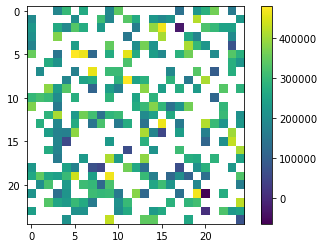

In [51]:
%matplotlib inline
# Plotting agent wealth
agent_counts = np.zeros((zm.grid.width, zm.grid.height))
for cell in zm.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = np.mean([obj.wealth for obj in cell_content if type(obj) == Actor])
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

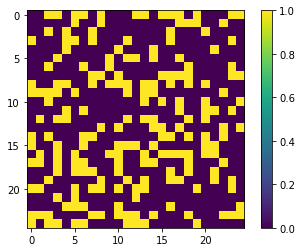

In [11]:
%matplotlib inline
# Plotting development -- yellow is developed, purple is undeveloped
neighborhood = np.zeros((zm.grid.width, zm.grid.height))
for cell in zm.grid.coord_iter():
    cell_content, x, y = cell
    cell_developed = len([obj for obj in cell_content if type(obj) == DevelopTag and obj.developed == True])
    neighborhood[x][y] = cell_developed
plt.imshow(neighborhood, interpolation='nearest')
plt.colorbar()

In [14]:
print(zm.population, len(zm.schedule.agents))

231 231


In [ ]:
avg_regulation = np.mean(zm.regulation_memory)

In [ ]:
avg_regulation

In [ ]:
zm.vacancy_memory

In [ ]:
h_affordability = get_Homeowner_Affordability(zm)
r_affordability = get_Renter_Affordability(zm)

In [ ]:
h_affordability

In [ ]:
r_affordability

In [ ]:
variable_params = {"homeowner_renter_ratio": [i/10 for i in range(1, 10, 1)]}

fixed_params = {
    "N": 200,
    "D": 200,
    "width": 25,
    "height": 25,
    "committee_size": 5,
    "regulation_impact": 0.08,
    "population_growth_rate": 0.01
}


# The variables parameters will be invoke along with the fixed parameters allowing for either or both to be honored.
batch_run = BatchRunner(
    ZoningModel,
    variable_params,
    fixed_params,
    iterations=1,
    max_steps=150,
    model_reporters={"Regulations": get_Regulations,
                     "Permits": get_Permits,
                     "Average Regulations": get_Average_Regulations,
                     "New Construction": get_Construction_Rate,
                     "Net Construction": get_Net_Construction,
                     "Total Construction": get_Housing_Stock,
                     "Total Population": get_Population,
                     "Population Growth": get_Population_Growth,
                     "Total Population Growth": get_Total_Population_Growth,
                     "Vacancies": get_Vacancies,
                     "Average Vacancy": get_Average_Vacancies,
                     "Occupancies": get_Occupancy,
                     "Homeowners": get_Homeowner_Number,
                     "Renters": get_Renter_Number,
                     "Homeowner Ratio": get_Homeowner_Ratio,
                     "Average Home Value": get_Average_Home_Value,
                     "Median Home Value": get_Median_Home_Value,
                     "Average Home Rent": get_Average_Home_Rent,
                     "Median Home Rent": get_Median_Home_Rent,
                     "Average Agent Wealth": get_Average_Agent_Wealth,
                     "Median Agent Wealth": get_Median_Agent_Wealth,
                     "Average Agent Budget": get_Average_Agent_Budget,
                     "Median Agent Budget": get_Median_Agent_Budget,
                     "Home Affordability": get_Homeowner_Affordability,
                     "Rent Affordability": get_Renter_Affordability,
                     "Percent Homeowner Payoff": get_Average_Homeowner_Payoff,
                     "Percent Renter Payoff": get_Average_Renter_Payoff}
)

batch_run.run_all()

In [ ]:
run_data = batch_run.get_model_vars_dataframe()
run_data

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=2)
run_data.plot.scatter(x='regulation_impact', y='Average Home Value', figsize=(13,8), ax = axes[0, 0])
run_data.plot.scatter(x='Homeowner Ratio', y='Average Home Value', figsize=(13,8), ax = axes[0, 1])
run_data.plot.scatter(x='regulation_impact', y='Average Regulations', figsize=(13,8),ax = axes[1, 0])
run_data.plot.scatter(x='Homeowner Ratio', y='Average Regulations', figsize=(13,8), ax = axes[1, 1])

plt.savefig('sensitivity_analysis_multi.png')

In [ ]:
X = run_data['Homeowner Ratio']
y = run_data['Average Regulations']

fig, ax = plt.subplots()
ax.scatter(X, y, marker='')

degree = 2
ax.plot(np.unique(X),
        np.poly1d(np.polyfit(X, y, degree))(np.unique(X)), color='black')

In [ ]:
run_data['const'] = 1

In [ ]:
X1 = ['const', 'Average Regulations']
X2 = ['const', 'Average Regulations', 'Total Population Growth']

price_regul_1 = sm.OLS(run_data['Average Home Value'], run_data[X1], missing = 'drop').fit()
price_regul_2 = sm.OLS(run_data['Average Home Value'], run_data[X2], missing = 'drop').fit()

info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[price_regul_1,price_regul_2],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Average Regulations',
                                             'Total Population Growth'])

results_table.add_title('Home Rent OLS Regressions')

print(results_table)

In [ ]:
X1 = ['const', 'Average Regulations']
X2 = ['const', 'Average Regulations', 'Total Population Growth']

rent_regul_1 = sm.OLS(run_data['Average Home Rent'], run_data[X1], missing = 'drop').fit()
rent_regul_2 = sm.OLS(run_data['Average Home Rent'], run_data[X2], missing = 'drop').fit()

info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[rent_regul_1,rent_regul_2],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Average Regulations',
                                             'Total Population Growth'])

results_table.add_title('Home Rent OLS Regressions')

print(results_table)

In [ ]:
X1 = ['const', 'Average Regulations']
X2 = ['const', 'Average Regulations', 'Total Population Growth']
X3 = ['const', 'Average Regulations', 'Total Population Growth', 'Average Vacancy']

supply_regul_1 = sm.OLS(run_data['Total Construction'], run_data[X1], missing = 'drop').fit()
supply_regul_2 = sm.OLS(run_data['Total Construction'], run_data[X2], missing = 'drop').fit()
supply_regul_3 = sm.OLS(run_data['Total Construction'], run_data[X3], missing = 'drop').fit()

info_dict={'No. observations' : lambda x: f"{int(x.nobs):d}"}

results_table = summary_col(results=[supply_regul_1,supply_regul_2,supply_regul_3],
                            float_format='%0.2f',
                            stars = True,
                            model_names=['Model 1',
                                         'Model 2',
                                         'Model 3'],
                            info_dict=info_dict,
                            regressor_order=['const',
                                             'Average Regulations',
                                             'Total Population Growth',
                                             'Average Vacancy'])

results_table.add_title('Housing Stock OLS Regressions')

print(results_table)

### Checking Property Values

In [69]:
zm = ZoningModel(200, 200, 25, 25, 0.70, 5, 0.15, 0.05)

In [70]:
dtags = []

In [71]:
for cell in zm.grid.coord_iter():
    for i in cell:
        if type(i) == set:
            for a in i:
                if type(a) == DevelopTag:
                    dtags.append(a)

In [72]:
for dtag in dtags:
    print(dtag.value)

295606.4401939756
None
None
None
None
209464.39176756103
None
None
None
None
None
291185.6926923434
None
119951.91996572148
None
None
None
None
None
None
419164.48646483605
None
None
None
None
None
None
275107.75986581016
None
None
242553.47777916904
235983.43118066143
191166.6273539515
None
None
None
None
230837.50801972687
None
None
None
None
None
238898.2969952184
185324.87519065692
None
None
None
None
None
None
None
None
None
281740.40106138686
None
None
None
None
None
None
None
None
357554.4847992669
None
352030.96282375173
216405.37029207146
None
None
None
None
435886.5141038622
None
None
381615.3905304152
None
None
282323.61058906454
None
None
None
None
None
None
None
None
None
239975.4085682935
None
99313.8229108841
None
None
None
421799.70867440884
332135.31918158435
None
294858.67543949746
None
None
396218.35659764183
None
181124.2860767489
251489.94082965387
None
None
None
None
None
208681.22483341306
None
None
None
None
None
296411.53513098176
None
None
None
None
None
None


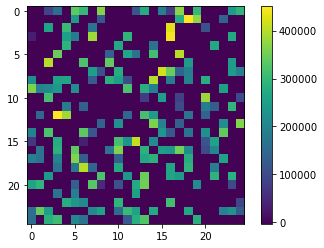

In [34]:
%matplotlib inline
# Plotting development -- yellow is developed, purple is undeveloped
neighborhood = np.zeros((zm.grid.width, zm.grid.height))
for cell in zm.grid.coord_iter():
    cell_content, x, y = cell
    cell_developed = len([obj for obj in cell_content if type(obj) == DevelopTag and obj.developed == True])
    cell_values = [obj.value for obj in cell_content if type(obj) == DevelopTag]
    for value in cell_values:
        if value == None:
            cell_values.remove(value)
            cell_values.append(0)
            #value = 0
    
    cell_value = sum(cell_values)
    neighborhood[x][y] = cell_value
plt.imshow(neighborhood, interpolation='nearest')
plt.colorbar()

In [75]:
ledger = []

In [79]:
agent_name = 'bob'
wealth = 50000

In [80]:
for dtag in dtags:
    if dtag.value and dtag.value < wealth:
        ledger.append([dtag, agent_name])

In [81]:
ledger

[[<__main__.DevelopTag at 0x275baa36e10>, 'bob'],
 [<__main__.DevelopTag at 0x275baa636d8>, 'bob'],
 [<__main__.DevelopTag at 0x275baa68438>, 'bob'],
 [<__main__.DevelopTag at 0x275baa7a0f0>, 'bob'],
 [<__main__.DevelopTag at 0x275baa7ab00>, 'bob']]

In [83]:
for record in ledger:
    print(record[0].value)
    record[0].owner = agent_name

45879.55868990923
25443.490211742377
33101.10258165703
11679.618106879934
41721.34081626136


In [84]:
for record in ledger:
    print(record[0].owner)

bob
bob
bob
bob
bob
